# Use Clay cleaned dataset to conduct UI subtree sequence generation

### 1. Get a dataset of all the UI components with their info

In [1]:
from PIL import Image
import pandas as pd
import json
import os
import sys
from treelib import Node, Tree

In [2]:
original_data_dir = "./data/original_data/"
screen_jpg_dir = {} # a dict of jpg file for the screen
screen_json_dir = {}    # a dict of json file for the screen

package_list = os.listdir(original_data_dir)

for package in package_list:    # for each package (i.e. app) in the dataset
        package_dir = original_data_dir + package + "/"
        if os.path.exists(package_dir):
            screen_file_list = os.listdir(package_dir)
        
            for screen_file in screen_file_list:    # for each file in the package (can be .json, .jpg, .txt)
                if screen_file.endswith(".jpg"):
                    screen_name = screen_file.split(".")[0]
                    screen_jpg_dir[screen_name] = package_dir + screen_file
                if screen_file.endswith(".json"):
                    screen_name = screen_file.split(".")[0]
                    screen_json_dir[screen_name] = package_dir + screen_file


screen_json_dir

{'13973': './data/original_data/com.abclocal.ktrk.news/13973.json',
 '13966': './data/original_data/com.abclocal.ktrk.news/13966.json',
 '13970': './data/original_data/com.abclocal.ktrk.news/13970.json',
 '13974': './data/original_data/com.abclocal.ktrk.news/13974.json',
 '13967': './data/original_data/com.abclocal.ktrk.news/13967.json',
 '13971': './data/original_data/com.abclocal.ktrk.news/13971.json',
 '13964': './data/original_data/com.abclocal.ktrk.news/13964.json',
 '13975': './data/original_data/com.abclocal.ktrk.news/13975.json',
 '13965': './data/original_data/com.abclocal.ktrk.news/13965.json',
 '13968': './data/original_data/com.abclocal.ktrk.news/13968.json',
 '26619': './data/original_data/com.omniluxtrade.pizzarecipes/26619.json',
 '26621': './data/original_data/com.omniluxtrade.pizzarecipes/26621.json',
 '26620': './data/original_data/com.omniluxtrade.pizzarecipes/26620.json',
 '5229': './data/original_data/com.omead.bible.kjv/5229.json',
 '5231': './data/original_data/c

In [3]:
def get_all_non_empty_items(subtree_list):
    results = []
    for subtree_item in subtree_list:
        if type(subtree_item) is list:
            inter_result = get_all_non_empty_items(subtree_item)
            if inter_result:
                results.extend(inter_result)
        else:
            if subtree_item:
                results.append(subtree_item)
    
    return results


# construct a clean tree using clay data from the screen's json file
def construct_tree(parent_node, json_file, clay_labels):
    subtree_root_id = json_file["pointer"]

    # check if there's any row in clay_labels for this screen and node
    exists_in_clay = ((clay_labels["screen_id"] == int(screen_id)) & (clay_labels["node_id"] == subtree_root_id)).any()

    if "children" not in json_file: # if it's a leaf node, just create it and return
        if exists_in_clay: 
            # if this node exists in clay dataset, that means it has semantic meaning, we work on it.
            # otherwise, we will just return empty
            # print("For screen " + screen_id + " and subtree " + subtree_root_id + ", ", end=" ")
            # print("it exists in clay, is a leaf node, current parent: " + parent_node)
            leaf_tree = Tree()
            leaf_tree.create_node(subtree_root_id, subtree_root_id)    

            # print("Leaf node " + str(subtree_root_id) + " created:")
            # leaf_tree.show()

            return leaf_tree
        else:
            return None
    
    else:   # if it's not a leaf node, we will recursively construct its subtree, append to the current node
        children_list = json_file["children"]
        
        if exists_in_clay:
            # first, construct the current node
            if parent_node is None: # if the tree is empty, then this node is root and thus has no parent
                # print("For screen " + screen_id + " and subtree " + subtree_root_id + ", ", end=" ")
                # print("it exists in clay, root node")
                result_tree = Tree()
                result_tree.create_node(subtree_root_id, subtree_root_id)
                
                # print("Root node " + str(subtree_root_id) + " created:")
                # result_tree.show()

                new_subtree_list = []
                for child in children_list:
                    # we will use the current node as its children's parent node
                    new_subtree = construct_tree(subtree_root_id, child, clay_labels)

                    if type(new_subtree) is list:
                        non_empty_new_subtree = get_all_non_empty_items(new_subtree)
                        new_subtree_list.extend(non_empty_new_subtree)

                    else:        
                        if new_subtree is not None:
                            new_subtree_list.append(new_subtree)
                        # else:
                            # print("Somehow the new subtree is None, the root for the empty subtree is: " + child["pointer"])


                for new_subtree in new_subtree_list:
                    result_tree.paste(subtree_root_id, new_subtree)
                return result_tree

            else:
                # print("For screen " + screen_id + " and subtree " + subtree_root_id + ", ", end=" ")
                # print("it exists in clay, middle_subtree, current parent: " + parent_node)
                middle_subtree = Tree()
                middle_subtree.create_node(subtree_root_id, subtree_root_id)
                
                # print("Middle node " + str(subtree_root_id) + " created:")
                # middle_subtree.show()

                new_subtree_list = []
                for child in children_list:
                    # we will use the current node as its children's parent node
                    new_subtree = construct_tree(subtree_root_id, child, clay_labels)

                    if type(new_subtree) is list:
                        non_empty_new_subtree = get_all_non_empty_items(new_subtree)
                        new_subtree_list.extend(non_empty_new_subtree)

                    else:        
                        if new_subtree is not None:
                            new_subtree_list.append(new_subtree)
                        # else:
                        #     print("Somehow the new subtree is None, the root for the empty subtree is: " + child["pointer"])

                for new_subtree in new_subtree_list:
                    middle_subtree.paste(subtree_root_id, new_subtree)

                # print("Middle subtree " + subtree_root_id + " finished creation, the tree structure: ")
                # middle_subtree.show()
                
                return middle_subtree

        else:   # if it doens't exist in clay, we will skip this and work on its child nodes
            # print("it doesn't exist in clay, mid_subtree, current parent is " + str(parent_node))
            new_subtree_list = []
            for child in children_list:
                # we use the current parent node as children's parent
                new_subtree = construct_tree(parent_node, child, clay_labels)
                new_subtree_list.append(new_subtree)
            return new_subtree_list
                
                
        


# convert a json into a sequence, use {} to denote parent-child relationship
def convert_tree_into_sequence(json_tree):

    # first, convert the tree into json
    tree_json = json.loads(json_tree.to_json())
    
    if type(tree_json) is str:
        return tree_json

    else:
        result_str = ""
        for key, value in tree_json.items():
            result_str += key + " { "
            if 'children' in value: # if it's not leaf node
                children_list = value['children']
                list_len = len(children_list) - 1

                for child in children_list:
                    result_str += convert_tree_into_sequence(child)
                    if children_list.index(child) != list_len:    # if it's not the last in the list
                        result_str += ", "
                result_str += " } "


        return result_str

In [20]:
clay_labels = pd.read_csv("./clay/clay_labels.csv")

# this is a test file
screen_id = "13966"
json_test = screen_json_dir[screen_id]
with open(json_test) as f:
    json_test_file = json.load(f)

root_node_json = json_test_file["activity"]["root"]


# construct a tree, using the treelib library

json_tree = construct_tree(None, root_node_json, clay_labels)

json_tree.show()

8a57c64
├── a4b15ce
│   └── 3eb90b
│       ├── 38c8edc
│       ├── 9853e8
│       ├── 992c694
│       ├── c918839
│       ├── da010a6
│       └── e2c9132
└── fc3a633
    ├── 1637df0
    │   ├── 1bb1925
    │   └── f5bef69
    │       ├── 108728f
    │       └── 14d1dee
    └── a23a8ab
        ├── 22922a1
        │   ├── 11447dd
        │   └── d96fcc6
        │       ├── 1722487
        │       └── c24dfb4
        └── c428223
            ├── c311d7f
            └── d9284d9



In [81]:
convert_tree_into_sequence(json_tree)

'332e52e { 80aa848 { d3038fc { 3223c9c, 4257e32, cab0b01, dcd3b85 }  } , 99e0805 { 799205a { 3aa628b { 5fc1f81, c147f68 } , 4da9c67 } , aca32bd { 389fc75 { 55d047b, 78aeaf1 } , 8ea9803 { 974b15f, b85d380 { 36c3db9, 5fad5fe }  }  }  }  } '

In [91]:
# get the clay_labels csv file
clay_labels = pd.read_csv("./clay/clay_labels.csv")

screen_tree_dict = {}

total_screen_cnt = len(screen_json_dir.keys())
current_screen_cnt = 0

for screen, path in screen_json_dir.items():
    print("Starting screen " + screen + "...")
    with open(path) as f:
        json_file = json.load(f)

    root_node_json = json_file["activity"]["root"]
    # construct a tree, using the treelib library
    json_tree = Tree()
    construct_tree(json_tree, None, root_node_json, clay_labels)
    json_tree.show()
    screen_tree_dict[screen] = convert_tree_into_sequence(json_tree)

    current_screen_cnt += 1
    print("Screen " + screen + " finished! ")
    print("Progress: " + '{:.1%}'.format(current_screen_cnt / total_screen_cnt * 100))

screen_tree_dict

Starting screen 13973...
For screen 13966 and subtree 332e52e,  it doesn't exist in clay
For screen 13966 and subtree e13c8cf,  it doesn't exist in clay
For screen 13966 and subtree 4b5c25c,  it doesn't exist in clay
For screen 13966 and subtree 1c3f965,  it doesn't exist in clay
For screen 13966 and subtree f8c263a,  it doesn't exist in clay
For screen 13966 and subtree d2e22eb,  it doesn't exist in clay
For screen 13966 and subtree 80aa848,  it doesn't exist in clay
For screen 13966 and subtree b7fc6e1,  it doesn't exist in clay
For screen 13966 and subtree 28eabc9,  it doesn't exist in clay
For screen 13966 and subtree 58c92ce,  it doesn't exist in clay
For screen 13966 and subtree ae975ef,  it doesn't exist in clay
For screen 13966 and subtree d3038fc,  it doesn't exist in clay
For screen 13966 and subtree dcd3b85,  it doesn't exist in clay
For screen 13966 and subtree 6630dda,  it doesn't exist in clay
For screen 13966 and subtree 3223c9c,  it doesn't exist in clay
For screen 1396

NodeIDAbsentError: Node 'None' is not in the tree

### 2. Parse UI Structure From Clay Dataset

From the cleaned clay dataset, parse UI structures from the json files. The parsing results are trees which each represent a screen in RICO.

Also, use the bounding box information to crop the elements out of the screenshots.

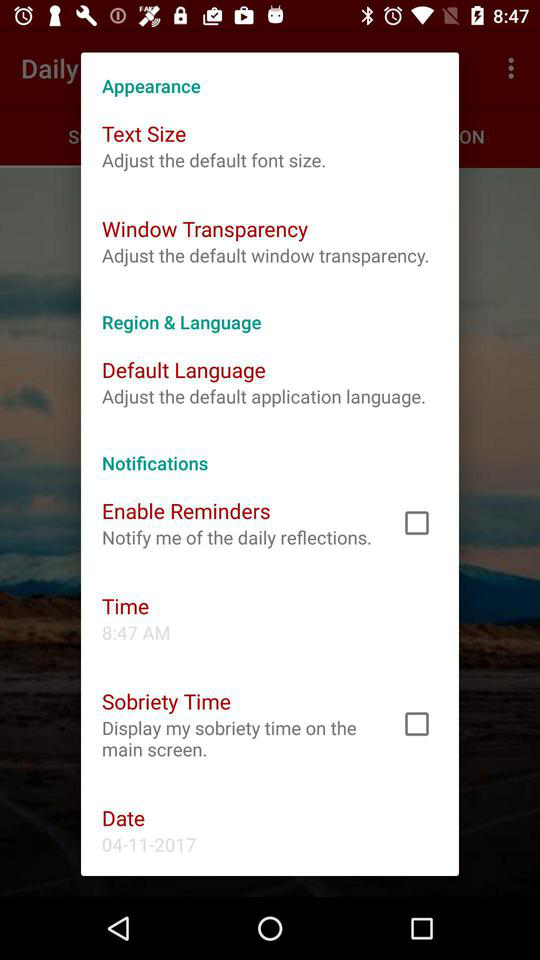

In [11]:
# Parse a screen as example
screen_id = 11371
screen_json_dir = "data/original_data/aa.apps.dailyreflections/11371.json"
screen_img_dir = "data/original_data/aa.apps.dailyreflections/11371.jpg"

ui_screenshot = Image.open(screen_img_dir)
ui_screenshot.show()

In [12]:
clay_labels = pd.read_csv("clay/clay_labels.csv")
screen_infos = clay_labels.loc[clay_labels["screen_id"] == screen_id]
screen_infos

,screen_id,node_id,label
1047402,11371,766258a,-1
1047403,11371,e0457ba,21
1047404,11371,a1ddbe2,19
1047405,11371,8f496a9,21
1047406,11371,5c1d42e,4
1047407,11371,bc18bcf,4
1047408,11371,b56f465,19
1047409,11371,c4a1f48,21
1047410,11371,ac771e1,4
1047411,11371,a43b06,4


In [25]:
# for each node_if, find its corresponding bounding box, store it in this dataframe
node_ids = screen_infos["node_id"].to_list()

f = open(screen_json_dir)
screen_json_file = json.load(f)
root_node = screen_json_file["activity"]["root"]
root_bound = root_node["bounds"]
root_children = root_node["children"]
print(root_bound)

[160, 84, 1280, 2392]
